<a href="https://colab.research.google.com/github/tamasdoka/weather_forecast/blob/master/Weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import copy
import pandas as pd
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(123)

Using TensorFlow backend.


In [0]:
#Import weather data in csv format from the last 7 years, in Budapest, Liszt Ferenc Airport
data = pd.read_csv("data_all.csv", error_bad_lines=False, delimiter=";") 

b'Skipping line 18330: expected 14 fields, saw 16\nSkipping line 30774: expected 14 fields, saw 16\nSkipping line 36617: expected 14 fields, saw 16\nSkipping line 40447: expected 14 fields, saw 16\nSkipping line 55599: expected 14 fields, saw 16\nSkipping line 64312: expected 14 fields, saw 16\nSkipping line 65530: expected 14 fields, saw 16\n'
b'Skipping line 70729: expected 14 fields, saw 16\nSkipping line 88767: expected 14 fields, saw 16\nSkipping line 97007: expected 14 fields, saw 16\nSkipping line 104450: expected 14 fields, saw 16\n'


In [0]:
data.tail()

,Local time in Budapest / Ferenc Liszt (airport),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td,Unnamed: 13
118912,26.09.2012 10:00,24.0,745.9,759.0,47.0,Wind blowing from the south,7.0,NaN,NaN,NaN,No Significant Clouds,10.0 and more,12.0,NaN
118913,26.09.2012 09:30,23.0,745.9,759.0,50.0,Wind blowing from the south,7.0,NaN,NaN,NaN,No Significant Clouds,10.0 and more,12.0,NaN
118914,26.09.2012 09:00,22.0,745.9,759.0,57.0,Wind blowing from the south,5.0,NaN,NaN,NaN,No Significant Clouds,10.0 and more,13.0,NaN
118915,26.09.2012 08:30,20.0,745.8,759.0,60.0,Wind blowing from the south,4.0,NaN,NaN,NaN,No Significant Clouds,10.0 and more,12.0,NaN
118916,26.09.2012 08:00,18.0,745.7,759.0,68.0,Wind blowing from the south-southeast,4.0,NaN,NaN,NaN,No Significant Clouds,10.0 and more,12.0,NaN


In [0]:
#Date and time is stored in one cell, so first we must split them into separate cells.
split1 = data["Local time in Budapest / Ferenc Liszt (airport)"].str.split(" ", n = 1, expand = True) 

#Split the date into 3 parts
split2 = split1[0].str.split(".", n = 2, expand = True)

#making separate date columns 
data["Day"]= split2[0]
data["Month"]= split2[1]
data["Year"]= split2[2]
  
# making separate time column, and replace 30 minutes into .5 hour
data["Time"]= split1[1]
data["Time"]= data["Time"].apply(lambda x:float(x.replace(":",".").replace("30", "5")))
  
# Dropping old columns, which we don't need anymore
data.drop(columns =["Local time in Budapest / Ferenc Liszt (airport)","P", "DD", "Ff", "ff10", "WW", "W'W'", "c", "VV", "Unnamed: 13"], inplace = True) 
data.drop(columns =["Year", "P0", "U", "Td"], inplace = True) 

#Dropping and checking the NaN values
data = data.dropna()

data.isnull().any()



T        False
Day      False
Month    False
Time     False
dtype: bool

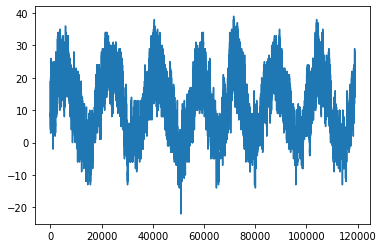

In [0]:
#Plotting temperature data
plt.plot(data['T'])

In [0]:
data.tail()

,T,Day,Month,Time
118912,24.0,26,09,10.0
118913,23.0,26,09,9.5
118914,22.0,26,09,9.0
118915,20.0,26,09,8.5
118916,18.0,26,09,8.0


In [0]:
#Creating train, test and validation data

dataset = data.values

test_split = 0.2
valid_split = 0.2

X = dataset[:,1:]
Y = dataset[:,0]

v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]
X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X = X[:v_index]
Y = Y[:v_index]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [0]:
#Setting the model parameters
patience=40
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

model = Sequential()
model.add(Dense(output_dim=100, input_dim=X.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(output_dim=10, activation='sigmoid'))
model.add(Dense(output_dim=1, activation='linear'))

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mse', optimizer=sgd)
history=model.fit(X,Y,epochs=100, 
                  batch_size=100,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[checkpointer, early_stopping])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=3, units=100)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=10)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  # Remove the CWD from sys.path while we load stuff.






Train on 71338 samples, validate on 23780 samples
Epoch 1/100





 - 8s - loss: 85.3566 - val_loss: 52.8171

Epoch 00001: val_loss improved from inf to 52.81708, saving model to weights.hdf5
Epoch 2/100
 - 3s - loss: 50.3885 - val_loss: 29.0610

Epoch 00002: val_loss improved from 52.81708 to 29.06105, saving model to weights.hdf5
Epoch 3/100
 - 3s - loss: 33.4694 - val_loss: 24.7053

Epoch 00003: val_loss improved from 29.06105 to 24.70526, saving model to weights.hdf5
Epoch 4/100
 - 3s - loss: 29.3923 - val_loss: 23.5736

Epoch 00004: val_loss improved from 24.70526 to 23.57357, saving model to weights.hdf5
Epoch 5/100
 - 3s - loss: 28.0771 - val_loss: 23.9172

Epoch 00005: val_loss did not improve from 23.57357
Epoch 6/100
 - 3s - loss: 27.2866 - val_loss: 24.3671

Epoch 00006: val_loss did not improve from 23.57357
Epoch 7/100
 - 3s - loss: 26.8244 - val_loss: 23.3398

Epoch 00007: val_loss improved from 23.57357 to 23.33979, saving model to weights.hdf5
Epoch 8/100
 - 3s - lo

In [0]:
#Loading back the best model
model = load_model('weights.hdf5')


from sklearn.metrics import mean_squared_error
model = load_model('weights.hdf5')
preds = model.predict(X_test)
test_err = mean_squared_error(Y_test,preds)
print("\nTest error: %f" % (test_err))


Test error: 22.199281


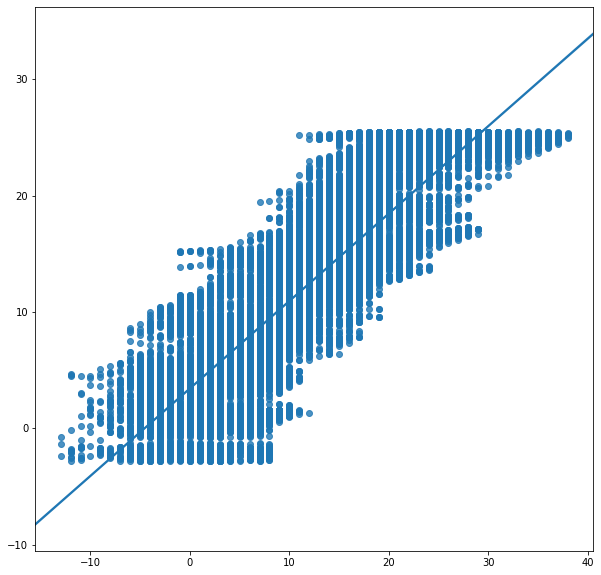

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.regplot(x=Y_test.astype(float), y=preds.reshape(-1));



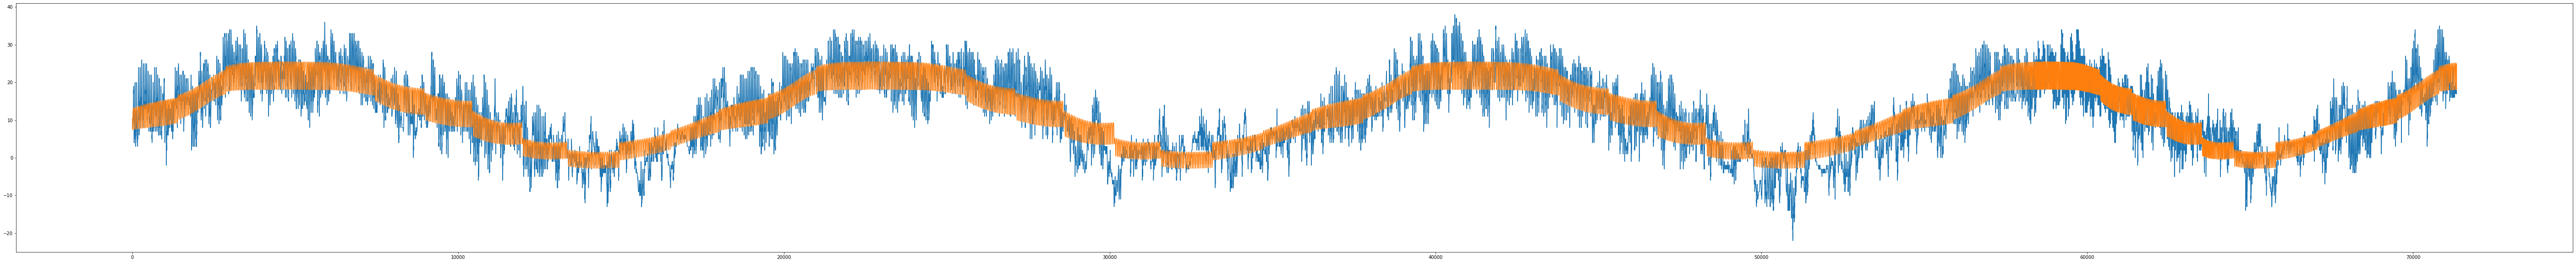

In [0]:
#Visualizing predictions

preds = model.predict(X)

plt.figure(figsize=(100,10))
plt.plot(Y.astype(float)[:105000])
plt.plot(preds[:105000])

10.162578582763672


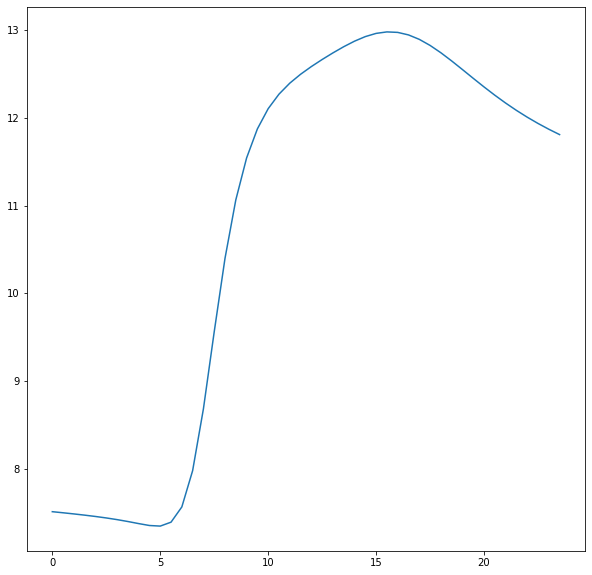

In [0]:
#Predict the temperatures for day: 2019.10.30

october = np.ones(48)*10
thirty = np.ones(48)*30

hours = np.arange(0,24,0.5)

m = october.reshape(48,1)
d = thirty.reshape(48,1)
h = hours.reshape(48,1)

#Creating the input for the given date
X_pred = np.concatenate((d,m,h), axis=1)

#Scaling the input data
X_pred_sc = scaler.transform(X_pred)

preds = model.predict(X_pred_sc)

plt.figure(figsize=(10,10))
plt.plot(X_pred[:,2],preds)

#Calculating the mid temperature for the day
guess = (np.max(preds) + np.min(preds))/2

print(guess)

8.883033752441406


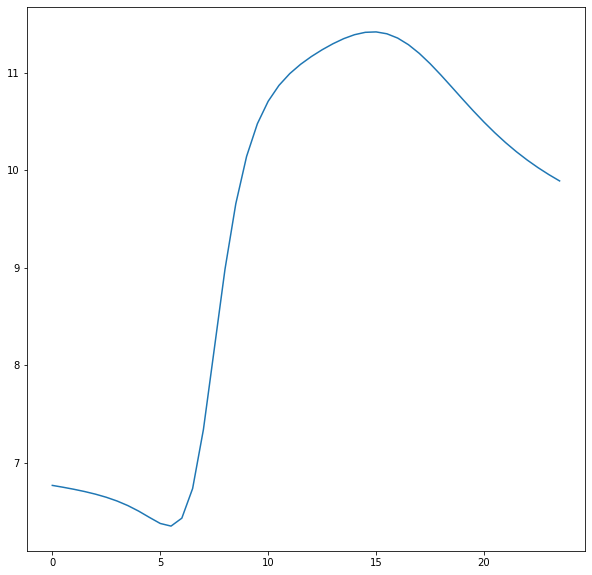

In [0]:
#Predict the temperatures for day: 2019.11.05

month = np.ones(48)*11
day = np.ones(48)*5

hours = np.arange(0,24,0.5)

m = month.reshape(48,1)
d = day.reshape(48,1)
h = hours.reshape(48,1)

#Creating the input for the given date
X_pred = np.concatenate((d,m,h), axis=1)

#Scaling the input data
X_pred_sc = scaler.transform(X_pred)

preds = model.predict(X_pred_sc)

plt.figure(figsize=(10,10))
plt.plot(X_pred[:,2],preds)

#Calculating the mid temperature for the day
guess = (np.max(preds) + np.min(preds))/2

print(guess)

5.61610746383667


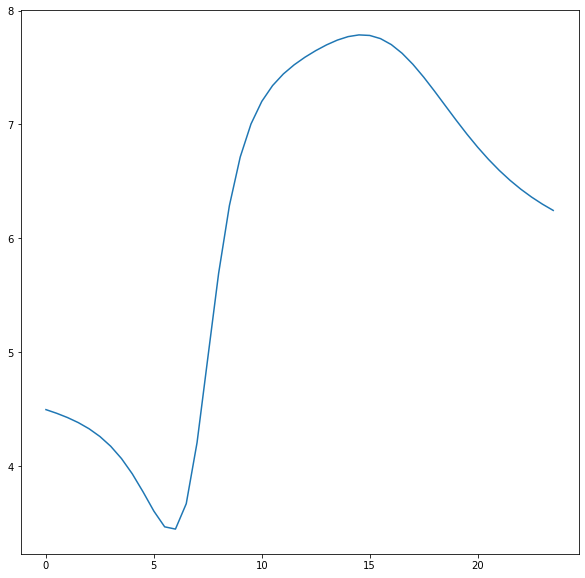

In [0]:
#Predict the temperatures for day: 2019.11.26

month = np.ones(48)*11
day = np.ones(48)*26

hours = np.arange(0,24,0.5)

m = month.reshape(48,1)
d = day.reshape(48,1)
h = hours.reshape(48,1)

#Creating the input for the given date
X_pred = np.concatenate((d,m,h), axis=1)

#Scaling the input data
X_pred_sc = scaler.transform(X_pred)

preds = model.predict(X_pred_sc)

plt.figure(figsize=(10,10))
plt.plot(X_pred[:,2],preds)

#Calculating the mid temperature for the day
guess = (np.max(preds) + np.min(preds))/2

print(guess)